In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
import logging
set_logger(logging.DEBUG)

In [4]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid', 'property_address_school_transactions']


In [5]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1475109, 25)
(709325, 22)


In [6]:
pp = Preprocess(df_transaction, df_property)

In [26]:
# records of last year
use_features = ['date', 'sqft', 'num_bed', 'num_bath', 'view', 'pool', 
                'sqft_zip_avg', 'sqft_price_zip_avg', 'sold_price_zip_avg', 
                'impr_over_land', 'lon', 'lat']
df_track = pp.dataset(feature='delivered', valid=True, date=('2015-10-01', '2017-10-01'))
monthly_volume = int(df_track.shape[0] / 24)
print(df_track.shape)
df_track.head()

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_month
[dp] transforming sold_age
[dp] transforming eval
[dp] transforming eval_sqft_price
[dp] making sqft_zip_avg
[dp] making sqft_over_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making eval_zip_avg
[dp] making eval_over_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon


(68906, 17)


,num_bath,lat,lon,num_bed,sold_price,sqft_zip_avg,date,impr_over_land,sqft_price_zip_avg,sqft_over_zip_avg,id,sold_price_zip_avg,eval_over_zip_avg,eval_zip_avg,pool,sqft,view
1,1.0,32.79673,-116.96671,1.0,158500,1678.766257,2015-10-01,1.250028,264.264499,0.436034,1392761,429138.400703,0.354392,456186.318102,0,732,0
39746,3.0,33.06851,-117.07649,4.0,815000,2411.534483,2015-10-01,1.742629,271.863506,1.292538,1392724,625932.471264,1.245316,667540.525862,1,3117,0
40442,2.0,33.20254,-117.22015,3.0,408000,2077.993659,2015-10-01,2.149506,251.584239,0.626085,1392725,496899.456522,0.782437,530962.631341,0,1301,0
40443,2.0,33.22698,-117.23104,3.0,365000,2077.993659,2015-10-01,1.580017,251.584239,0.701638,1392777,496899.456522,0.701177,530962.631341,0,1458,0
40444,2.0,33.25058,-117.22204,3.0,635000,2077.993659,2015-10-01,1.190484,251.584239,1.157366,1392813,496899.456522,1.455846,530962.631341,1,2405,1


## Random Forest Model

10-fold cross-validation to select the best number of trees and depth of each tree in the forest.

In [27]:
monthly_volume

2871

In [36]:
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
mm = ModelManager(df_track, use_features, rf, time_series=True)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 57422, 34452, 11484
[dp] validation step is skipped
[dp] training size: 34452


128502.95066276925

In [49]:
#df_check = mm.get_result_df(pp)
df_check = pp.debug(mm.get_result_df())
df_check['sqft_price'] = df_check['sold_price'] / df_check['sqft']

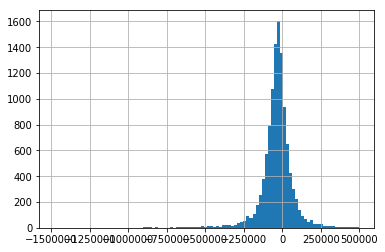

In [42]:
df_check[df_check['residual']<500000]['residual'].hist(bins=100)

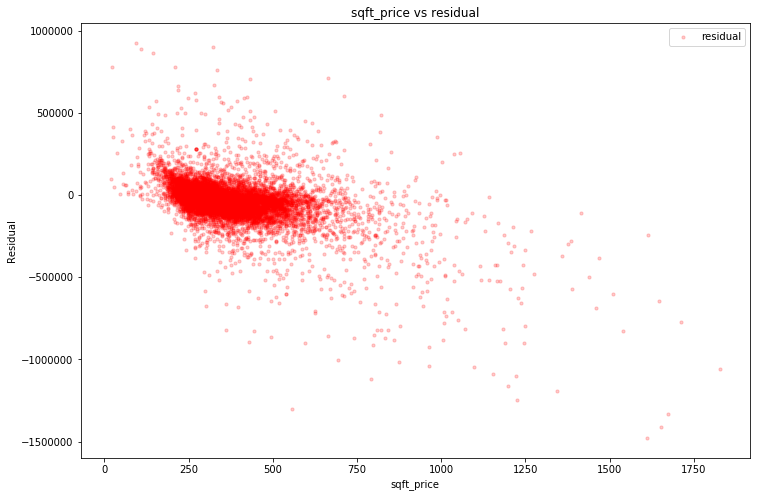

In [43]:
plt.figure(figsize=(12,8))
plt.scatter(df_check['sqft_price'], df_check['residual'], s=10, c='r', alpha=0.2)
plt.xlabel('sqft_price')
plt.ylabel('Residual')
plt.legend(loc='best');
plt.title('sqft_price vs residual')

plt.show()

In [13]:
def remeasure(df_check, threshold=200000):
    removed = df_check[df_check['residual']>=threshold]
    print("removed records:", removed.shape[0])
    df_left = df_check[df_check['residual']<threshold]
    return sqrt(mean_squared_error(df_left['predict'], df_left['sold_price']))

In [14]:
remeasure(df_check)

removed records: 224


118672.81512811533

### removing outliers
* by option clean=True which remove outliers that are 1.5 IQR outside of Hinge-spread

In [66]:
df_track_clean = pp.dataset(feature='delivered', valid=True, clean=True, date=('2015-10-01', '2017-10-01'))
monthly_volume = int(df_track_clean.shape[0] / 24)
print(df_track_clean.shape)
df_track.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_month
[dp] transforming sold_age
[dp] transforming eval
[dp] transforming eval_sqft_price
[dp] making sqft_zip_avg
[dp] making sqft_over_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making eval_zip_avg
[dp] making eval_over_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon


(61629, 17)


(68906, 17)

In [67]:
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
mm = ModelManager(df_track_clean, use_features, rf, time_series=True)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 51361, 30804, 10268
[dp] validation step is skipped
[dp] training size: 30804


98401.42443242903

In [65]:
df_check_clean = pp.debug(mm.get_result_df())
df_check_clean['sqft_price'] = df_check_clean['sold_price'] / df_check_clean['sqft']
remeasure(df_check_clean)

removed records: 149


98660.12367422503

In [68]:
df_check_clean[df_check_clean['residual']>600000][:3]

,pin,str_no,street,st_type,city,zip,land_use_subcode,date,sqft,num_bed,...,sqft_price_zip_avg,sold_price_zip_avg,impr_over_land,lon,lat,id,sold_price,predict,residual,sqft_price
4518,2982832600,839,IDA,AVE,SOLANA BEACH,92075,11,2017-07-20,2487,3.0,...,634.214286,1.141972e+06,0.183824,-117.25607,32.98449,1467236,805000,1.753654e+06,948654.353273,323.683152
7179,1292922400,1919,GRAND,AVE,SAN DIEGO,92109,11,2017-08-17,2368,3.0,...,543.598891,7.274376e+05,1.986509,-117.23439,32.79908,1470684,635000,1.308431e+06,673430.702561,268.158784
7614,1491001900,169,PARNASSUS,CIR,OCEANSIDE,92054,11,2017-08-22,3848,6.0,...,396.840304,5.748408e+05,2.542392,-117.34536,33.20757,1471239,361000,1.222046e+06,861045.505952,93.814969


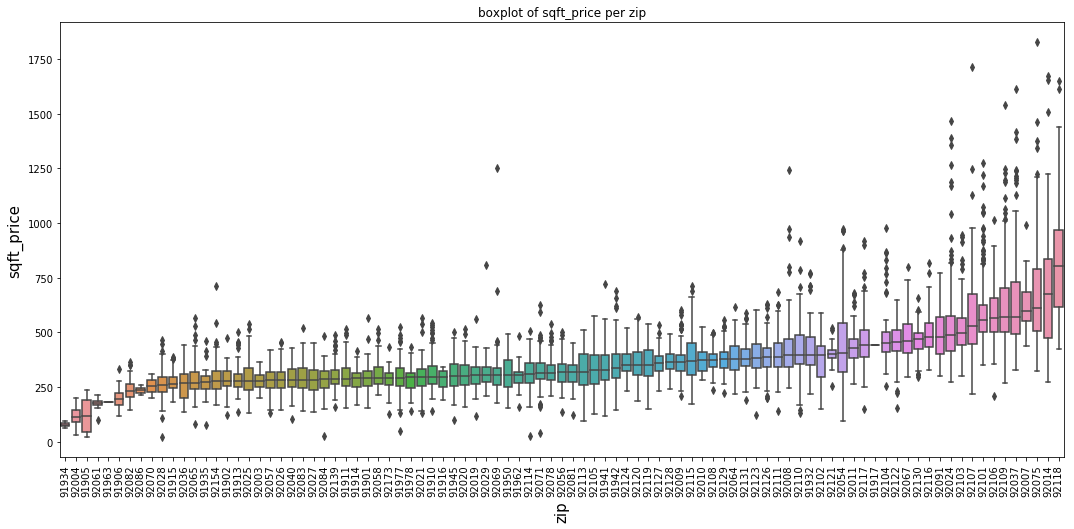

In [69]:
plot_box(df_check, 'zip', 'sqft_price', order=True)

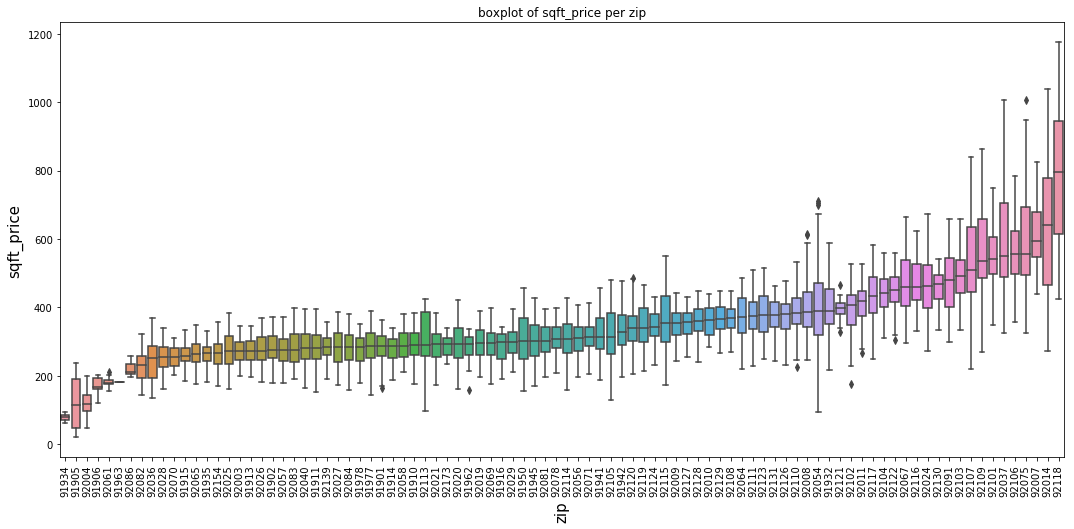

In [70]:
plot_box(df_check_clean, 'zip', 'sqft_price', order=True)

In [72]:
stats = pp.get_zip_stats(df_check)
df_bounds = pd.DataFrame.from_dict(stats)
#df_bounds = df1.transpose()

Text(0,0.5,'median')

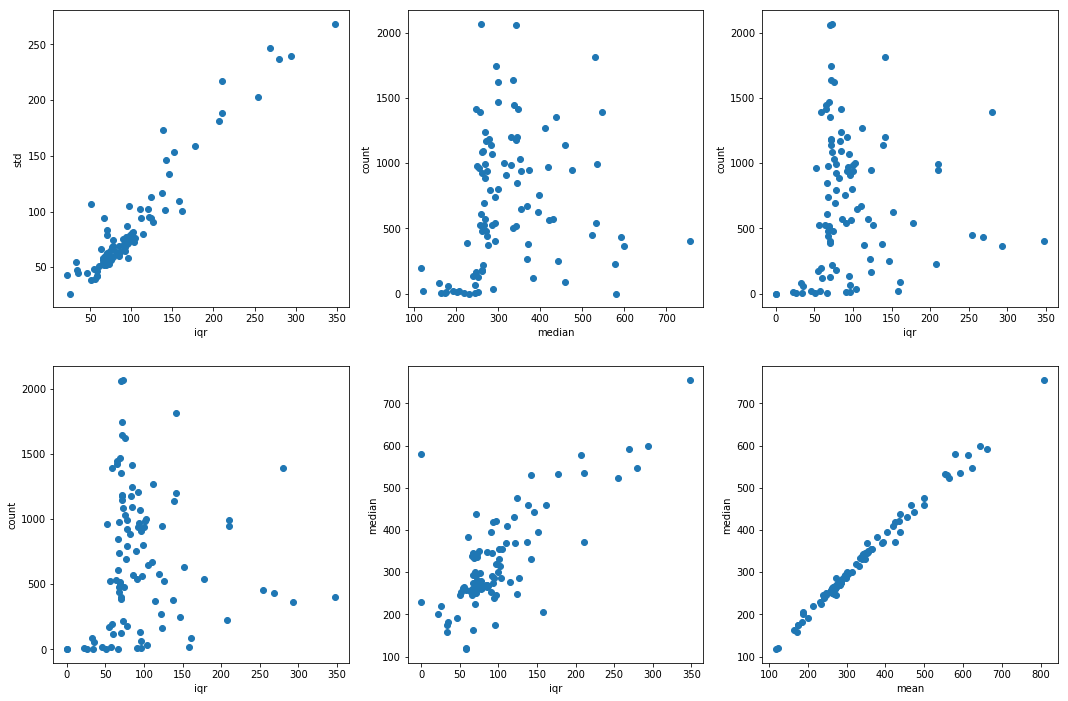

In [159]:
fig, ax = plt.subplots(2,3, figsize=(18,12))
ax[0,0].scatter(df_bounds['iqr'], df_bounds['std'])
ax[0,0].set_xlabel('iqr')
ax[0,0].set_ylabel('std')
ax[0,1].scatter(df_bounds['median'], df_bounds['count'])
ax[0,1].set_xlabel('median')
ax[0,1].set_ylabel('count')
ax[0,2].scatter(df_bounds['iqr'], df_bounds['count'])
ax[0,2].set_xlabel('iqr')
ax[0,2].set_ylabel('count')

ax[1,0].scatter(df_bounds['iqr'], df_bounds['count'])
ax[1,0].set_xlabel('iqr')
ax[1,0].set_ylabel('count')

ax[1,1].scatter(df_bounds['iqr'], df_bounds['median'])
ax[1,1].set_xlabel('iqr')
ax[1,1].set_ylabel('median')

ax[1,2].scatter(df_bounds['mean'], df_bounds['median'])
ax[1,2].set_xlabel('mean')
ax[1,2].set_ylabel('median')

In [121]:
df_bounds[df_bounds['count']<100].sort_values(by='count')

,lower,upper,iqr,count,median
92536,230.113636,230.113636,0.000000,1.0,230.113636
92059,579.601990,579.601990,0.000000,1.0,579.601990
92066,30.443063,297.166387,66.680831,2.0,163.804725
91980,106.960409,241.060026,33.524904,2.0,174.010217
91948,163.328540,266.664945,25.834101,3.0,214.996742
91917,157.708628,359.500236,50.447902,5.0,258.604432
91963,148.567373,235.407210,21.709959,10.0,191.987291
92070,78.366383,441.255437,90.722264,11.0,259.810910
92060,-17.113903,364.899087,95.503248,12.0,173.892592
91934,4.094135,235.341684,57.811887,17.0,119.717910
